In [1]:
import sys, platform, os
print(sys.version)
print("--"* 60)
print("sys.platform   :", sys.platform)
print("platform.system():", platform.system())  
print("os.name :", os.name)   
# print(sys.executable)
# print("--"* 60)

3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]
------------------------------------------------------------------------------------------------------------------------
sys.platform   : win32
platform.system(): Windows
os.name : nt


In [2]:
# -------------------------------
# Current working directory
# -------------------------------
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: C:\Users\alkas\Downloads\Cell_Cycle_updated_Files\Cell_Cycle_updated_Files\All_DATA_Code_Files


In [3]:
# Import necessary libraries
import numpy as np   
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp 

In [4]:
## Temporary directory
import tempfile
tempfile.gettempdir()

'C:\\Users\\alkas\\AppData\\Local\\Temp'

In [5]:
import pytisean.pytisean ## See the pytisean.py
if sys.platform.startswith("win"):
    pytisean.pytisean.DIRSTR = r"C:\TiseanTemp\\"
    os.makedirs(pytisean.pytisean.DIRSTR, exist_ok=True)
else:  
    pytisean.pytisean.DIRSTR = tempfile.gettempdir()

In [6]:
# Import the wrapper functions
from pytisean import tiseanio, tiseano
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Import helper
from plot_utils import set_plot_style, set_spines_black
set_plot_style()

In [7]:
# -------------------------------
#  Generate the Training Data
# --------------------------------
alpha1, alpha2, alpha3 = 0.2, 3, 3
beta1, beta2 = 3, 1
K1,K3 = 0.5, 0.5
n1, n2, n3 = 8, 8, 8

# Define the System of ODEs, x1 = CDK1*, x2 = APC*
def two_dim(x, t):
    x1, x2 = x
    dx1_dt = alpha1- beta1*x1*(x2**n1/(K1**n1 + x2**n1))+ alpha3*(1 - x1)*(x1**n3/(K3**n3 + x1**n3))
    dx2_dt = alpha2*(1 - x2)*( x1**n2/(K3**n2 + x1**n2))- beta2*x2
    return [dx1_dt, dx2_dt]
    

# Initial conditions
x0 = [0, 0]
## Time points for the simulation
dt = 0.05
t0 = 0
tf= 500
t_train = np.arange(t0, tf + dt, dt)
## Solve the ODEs
X  = odeint(two_dim, x0, t_train)

In [8]:
# Print sizes of t_train, X 
print("Size of t_train:", t_train.shape)
print("Size of X:", X.shape)

Size of t_train: (10001,)
Size of X: (10001, 2)


In [9]:
x_t = X[:,0] # Choose x(t), a scaler time series

In [10]:
N = len(x_t)  # Get the length of the time series
print("The length of the time series x(t) is:", N)

The length of the time series x(t) is: 10001


## Time Delay

In [11]:
autocor_information, msg = tiseanio('autocor','-V',0, data=x_t)
autocor_information.shape

['autocor', 'C:\\TiseanTemp\\pytisean_temp_2025-09-09-16-30-28_mfjjcjw_.dat', '-V', '0', '-o', 'C:\\TiseanTemp\\pytisean_temp_2025-09-09-16-30-28_e9pl4s0v.dat']



(10001, 2)

In [12]:
time_delays = autocor_information[:, 0]  # The lag values (time delays)
autocorrelation_values = autocor_information[:, 1]  # The autocorrelation values
# Find time delay based on first crossing a threshold, e.g., 1/e
threshold = np.exp(-1)  # 1/e ≈ 0.37 
# Find the first index where autocorrelation falls below or equal to the threshold
time_delay_idx = np.where(autocorrelation_values <= threshold)[0][0]  # First crossing of 1/e
time_delay_value = time_delays[time_delay_idx]


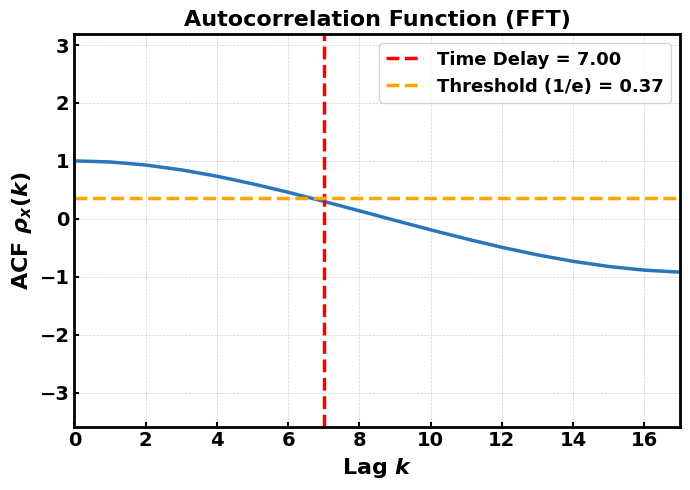

Selected  delay: 7.0


In [13]:
# Plot the autocorrelation and mark the selected time delay
bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('Autocorrelation Function (FFT)')
ax.plot(time_delays, autocorrelation_values, color=bluish)
ax.set_xlabel(r'Lag $k$')
ax.set_ylabel(r'ACF $\rho_x(k)$')
plt.grid(True, which='both', ls='--', lw=0.5)

# Mark the time delay
ax.axvline(x=time_delay_value, color='r', linestyle='--', label=f'Time Delay = {time_delay_value:.2f}')
# Mark the threshold
ax.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold (1/e) = {threshold:.2f}')
set_spines_black(ax)
ax.legend()
ax.set_xlim(0, time_delay_idx + 10) 

plt.savefig("Plots_1/TimeDelay_Example_1.pdf", bbox_inches="tight")
plt.show()

print(f"Selected  delay: {time_delay_value}")


## Embedding Dimesion

['false_nearest', 'C:\\TiseanTemp\\pytisean_temp_2025-09-09-16-30-30_01jl889z.dat', '-m', '1', '-M', '1,5', '-d', '7', '-f', '3', '-V', '0', '-o', 'C:\\TiseanTemp\\pytisean_temp_2025-09-09-16-30-30_t9uikn5n.dat']



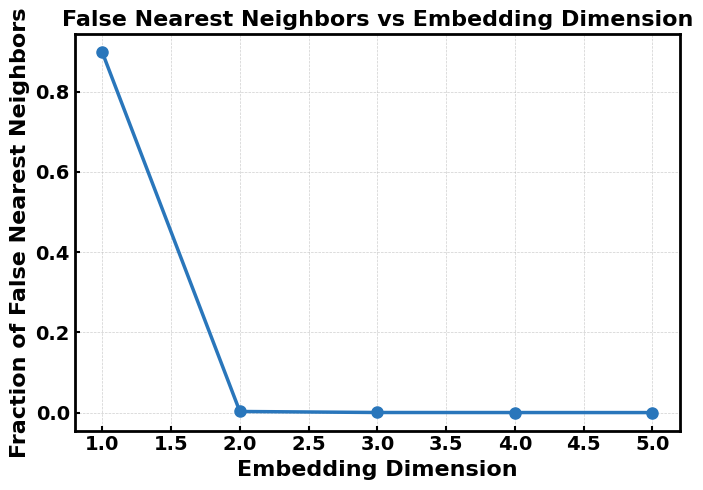

In [14]:
fnn_information, msg = tiseanio('false_nearest', '-m', 1, '-M', '1,5', '-d', 7, '-f',3, '-V',0, data=x_t)
# Plot the fraction of false nearest neighbors against embedding dimension
embedding_dimensions = fnn_information[:, 0]  # First column: embedding dimensions
fnn_values = fnn_information[:, 1]            # Second column: fraction of false nearest neighbors

bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('False Nearest Neighbors vs Embedding Dimension')
ax.plot(embedding_dimensions, fnn_values, color=bluish, marker='o')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Fraction of False Nearest Neighbors')
set_spines_black(ax)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.savefig("Plots_1/Embedding_Dimension__Example_1.pdf", bbox_inches="tight")
plt.show()


In [15]:
fnn_values

array([8.975517e-01, 2.810116e-03, 3.011141e-04, 2.007629e-04,
       1.003915e-04])

In [16]:
## Time Delay = 7
## Embedding Dimension = 2

In [17]:
# To generate delay vectors
delay_information, msg = tiseanio('delay', '-m', 5, '-d', 5, '-V', 0, data=x_t)

['delay', 'C:\\TiseanTemp\\pytisean_temp_2025-09-09-16-30-31_nwvekt0_.dat', '-m', '5', '-d', '5', '-V', '0', '-o', 'C:\\TiseanTemp\\pytisean_temp_2025-09-09-16-30-31_gkx1zz9v.dat']



In [18]:
delay_information

array([[0.2001799 , 0.1500143 , 0.1000004 , 0.05      , 0.        ],
       [0.2102763 , 0.1600252 , 0.1100009 , 0.06000001, 0.01      ],
       [0.2204162 , 0.170043  , 0.120002  , 0.07000003, 0.02      ],
       ...,
       [0.4522547 , 0.353154  , 0.3216454 , 0.3740596 , 0.482299  ],
       [0.4879971 , 0.3662808 , 0.322733  , 0.3555352 , 0.4622763 ],
       [0.5296277 , 0.3818994 , 0.3267824 , 0.3407934 , 0.4407246 ]],
      shape=(9981, 5))

In [19]:
#***************************************************************************************************************************************